# Webscraping

In this blog post I will discuss the following question:  
    *What movie or TV shows share actors with your favorite movie or show?*

And the link to my project repository:  
    https://github.com/libbyrencc/post/tree/main/post2

### 1.Setup

First, we need to setup our webscraping environment, remember to install scrapy package in your conda environment.

And run the following command in your terminal to initialize the project:

In [ ]:
conda activate PIC16B
scrapy startproject IMDB_scraper
cd IMDB_scraper


Now the file of scraper should be constructed correctly. Go to /IMDB_scraper/spiders/, and create a file "imdb_spider.py". And add following code to the start of the file

In [2]:
import scrapy

class ImdbSpider(scrapy.Spider):
    name = 'imdb_spider'
    
    start_urls = ['https://www.imdb.com/title/tt1533117/']
                #You can change your favorite film's url here
                #Here I choose my favorite film: Let the Bullets Fly

## Implement three parsing methods for the ImdbSpider class

### 1. prase(self,response)

First we start writing the prase method. It should start on a movie page, and then navigate to the Cast&Crew page.  
And call the next method prase_full_credits(self,response).

Here I use the CSS selector to find the URL of the Cast&Crew page
and yeild scrapy.Request

In [ ]:
 def parse(self, response):
        next_page = response.css("a.ipc-metadata-list-item__icon-link").attrib["href"]
        #Find the partial url by located tag <a> with
        #class= ipc-metadata-list-item__icon-link
        # and url is in "herf"
        if next_page:           
            next_page=response.urljoin(next_page) 
            #Here we make the URL complete
            yield scrapy.Request(next_page,callback= self.prase_full_credits)
            #Call next function

### 2. prase_full_credits(self, response)  
Now we are at the Cast&Crew page, next we should look at each actors' page, and call the next method prase_actor_page(self,response)  

We will use the css selector and the list comprehension to mimic the process of clicking on the headshots on this page.

Here we select `<a>` tag, which is under `<td>` tag with `class ='primary_photo'`, and url is still in `"herf"`.
Then we iterate each Cast&Crews' URL, use it as a parameter to call next method.

In [ ]:
def prase_full_credits(self,response):
        for next_page in [a.attrib["href"] for a in response.css("td.primary_photo a")]:
            next_page=response.urljoin(next_page)
            yield scrapy.Request(next_page,callback= self.prase_actor_page)

### 3. prase_actor_page(self,response)  
In each actors' page, we should first look up the actor's name.  
Then we find each movie or TV name below.  
Finally we yield a dictionary with two key-value pairs, of the form {"actor" : actor_name, "movie_or_TV_name" : movie_or_TV_name}.

In [ ]:
def prase_actor_page(self,response):
        actor_name=response.css("h1.header span.itemprop::text").get() 
        #get actor's name
        #the name is in <h1 class="header"><span class+"itemprop">name<\span><\h1>
        for quote in response.css("div.filmo-row"): 
            #get a list of  his/her works
            movie_or_TV_name=quote.css("b a::text").get()
            # the name is in <b> <a>work name<\a><\b>, under tag <div> with class ="filmo-row"
            yield {"actor" : actor_name, "movie_or_TV_name" : movie_or_TV_name} 
            #yeild an dictionary

Now we are done! The finally project looks like below:

In [ ]:
import scrapy

class ImdbSpider(scrapy.Spider):
    name = 'imdb_spider'
    
    start_urls = ['https://www.imdb.com/title/tt1533117/']

    def parse(self, response):
        next_page = response.css("a.ipc-metadata-list-item__icon-link").attrib["href"]
        if next_page:           
            next_page=response.urljoin(next_page)
            yield scrapy.Request(next_page,callback= self.prase_full_credits)

    
    
    def prase_full_credits(self,response):
        for next_page in [a.attrib["href"] for a in response.css("td.primary_photo a")]:
            next_page=response.urljoin(next_page)
            yield scrapy.Request(next_page,callback= self.prase_actor_page)

    def prase_actor_page(self,response):
        actor_name=response.css("h1.header span.itemprop::text").get()                             
        for quote in response.css("div.filmo-row"):
            movie_or_TV_name=quote.css("b a::text").get()
            yield {"actor" : actor_name, "movie_or_TV_name" : movie_or_TV_name}

And to run this web scraper we build, we need to run the command below in this repository.  
It will save all the results to results.csv

In [ ]:
scrapy crawl imdb_spider -o results.csv

## Data analysis  

Import some useful package first

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

read reasults.csv as pandas dataframe

In [2]:
results=pd.read_csv("results.csv")
results

,actor,movie_or_TV_name
0,Marco Ma,Gone with the Bullets
1,Marco Ma,Let the Bullets Fly
2,Marco Ma,Pk.com.cn
3,Marco Ma,The Blossom of Roses
4,Marco Ma,Let the Bullets Fly
...,...,...
885,You Ge,The Troubleshooters
886,You Ge,Shan de nu er
887,You Ge,Sheng xia he ta de wei hun fu
888,You Ge,The 11th China Movie Awards


Now we use aggregation to count each movie or TV contians how many shared actors

In [3]:
k=results.groupby(["movie_or_TV_name"])["actor"].aggregate(len)
k=k.reset_index()
k

,movie_or_TV_name,actor
0,"""Swordsmen of the Passes""",2
1,100 Ways to Murder Your Wife,1
2,1911,2
3,1921,1
4,2000 Blockbuster Entertainment Awards,1
...,...,...
663,Zhi Ming Yuan Wang,1
664,Zhongkui: Snow Girl and the Dark Crystal,1
665,Zou dao di,1
666,Zou xi kou,1


Then sort it by actors number

In [4]:
k=k.sort_values(by=["actor"],ascending=False).reset_index(drop=True)
k.head(10)

,movie_or_TV_name,actor
0,Let the Bullets Fly,34
1,Gone with the Bullets,10
2,The Sun Also Rises,9
3,The Founding of a Republic,8
4,Hidden Man,8
5,If You Are the One 2,6
6,I Love My Family,5
7,The Robbers,5
8,Assembly,5
9,Beginning of the Great Revival,5


Then we can try to visulaize it.

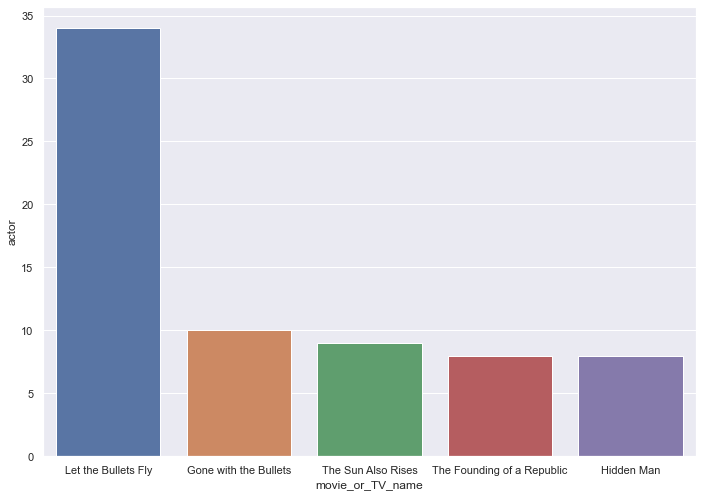

In [8]:
sns.barplot(x='movie_or_TV_name', y='actor', data=k.head(5))
sns.set(rc={'figure.figsize':(15,8.27)})

It shows that Gone with the Bullets may be a good choice for me since it shares most same actors.